##Setup

In [1]:
%matplotlib inline

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/python-2.7.6/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from showit import image, tile
import matplotlib.animation as animation

In [4]:
import thunder

In [5]:
import json

In [6]:
from os.path import join, exists
from os import mkdir, makedirs

##Set directory and session information

In [8]:
directory = '/tier2/freeman/Nick/lfov.calibration'

In [9]:
key = '2016-04-01'
name = 'anm-0326049'

In [10]:
path = join(directory, 'reprocessed', name, key)
print exists(path)

True


##Create savepath

In [11]:
savepath = join(path, 'movies')
if not exists(savepath):
    makedirs(savepath)

##Create movie

In [101]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=12000)

##Load data

In [48]:
data = thunder.images.frombinary(join(path, 'registered'), engine=sc)

In [49]:
data

Images
mode: spark
dtype: int16
shape: (11769, 4, 512, 512)

##Load meta data

In [16]:
summarypath = join(directory, 'reprocessed', name, key, 'summary')
with open(summarypath + '/meta.json') as infile:
    meta = json.load(infile)

In [162]:
meta

{u'averaging': u'_Inf_',
 u'depths': 250,
 u'nplanes': 1,
 u'nrois': 4,
 u'power': 70,
 u'rois': [{u'center': [0.9736104248276931, 1.9795404683152],
   u'depths': 100,
   u'npixels': [512, 512],
   u'size': [0.59, 0.6082310360000001]},
  {u'center': [3.2661912999940412, 2.2407711968943],
   u'depths': 100,
   u'npixels': [512, 512],
   u'size': [0.59, 0.6082310360000001]},
  {u'center': [1.0141826692331477, 4.1385770874861],
   u'depths': 100,
   u'npixels': [512, 512],
   u'size': [0.59, 0.6082310360000001]},
  {u'center': [3.353594750543545, 3.8294048154915004],
   u'depths': 100,
   u'npixels': [512, 512],
   u'size': [0.59, 0.6082310360000001]}],
 u'shape': [11769, 4, 512, 512],
 u'volumeRate': 9.600614439}

In [74]:
pixelsPerUmOrig = meta['rois'][0]['npixels'][0]/meta['rois'][0]['size'][0]/1000
aspect = meta['rois'][0]['size'][0]/meta['rois'][0]['size'][1]
volumeRate = meta['volumeRate']
scaleBar = 100*round(meta['rois'][0]['size'][0]*2)

##Transform data

In [102]:
fSpace = 1
dsTime = 10
dsSpace = 1
frameRate = volumeRate/dsTime
pixelsPerUm = pixelsPerUmOrig/dsSpace

In [103]:
if fSpace > 1:
    filtered = data.median_filter((1, fSpace, fSpace))
else:
    filtered = data

In [104]:
if dsSpace > 1:
    filtered = filtered.subsample((1, dsSpace, dsSpace))

In [105]:
from numpy import convolve, ones

In [106]:
def smooth(s, dsTime):
    r = convolve(s, ones(dsTime)/dsTime, 'same').astype('int16')
    return r[::dsTime]

In [107]:
if dsTime > 1:
    smoothed = filtered.map_as_series(lambda x: smooth(x, dsTime))
else:
    smoothed = filtered

In [ ]:
result = smoothed.toarray()

##DFF movie

In [170]:
from numpy import percentile

In [188]:
def dff(F):
    #F0 = F.mean()
    F0 = percentile(F,20)
    offset = 20
    return (F - F0)/(F0+offset)

In [189]:
normed = smoothed.map_as_series(dff)

In [190]:
result = normed.toarray()

##Extract single plane

In [192]:
plane = 0
if len(result.shape) == 3:
    plane = 0
    movie = result
else:
    movie = result[:,plane,:,:]
means = movie.mean()
label = 'movie_DFF_3'
clim = 8.0/4 #3.0/4 #means

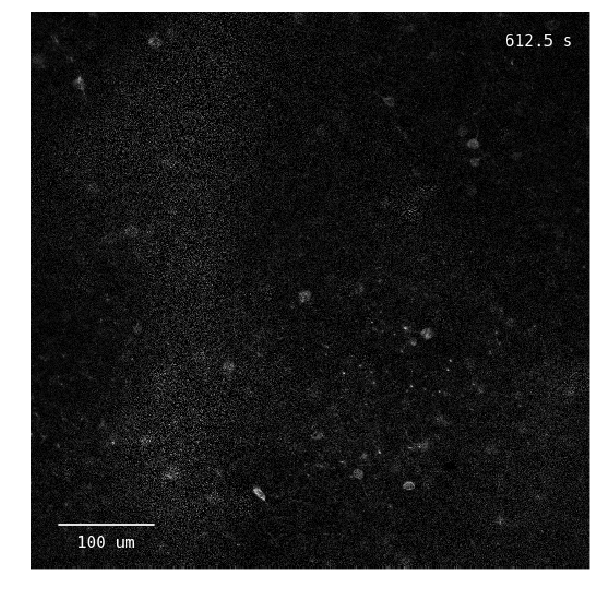

In [193]:
frame = movie.shape[0]/2
img = movie[frame,:,:]

fig = plt.figure(figsize=[10, 10])
ax = plt.gca()
im = image(img, clim=(0, 4*clim), ax=ax)

time = ax.text(.97*img.shape[1], .06*img.shape[0], '%.1f s' % (frame/frameRate), color='white', fontsize=16, ha='right', fontdict={'family': 'monospace'});
ax.plot([.05*img.shape[1], .05*img.shape[1]+scaleBar*pixelsPerUm], [.92*img.shape[0], .92*img.shape[1]], 'w');
sclae = ax.text(.05*img.shape[1]+scaleBar*pixelsPerUm/2, .96*img.shape[0], '%d um' % scaleBar, color='white', fontsize=16, ha='center', fontdict={'family': 'monospace'});
plt.xlim([0, img.shape[1]]);
plt.ylim([img.shape[0], 0]);

In [185]:
nframes = movie.shape[0]-dsTime

def update(frame):
    im.set_array(movie[dsTime/2+frame,:,:])
    time.set_text('%.1f s' % ((dsTime/2+frame)/frameRate))

ani = animation.FuncAnimation(fig, update, nframes, blit=False)
ani.save(join(savepath, '%s_ds%d_fs%d_dt%d-%d.mp4' % (label, dsSpace, fSpace, dsTime, plane)), writer=writer)

##Tile 4-plane movie

In [196]:
movie = result
means = movie.mean(axis=(0,2,3))
label = 'tiled_DFF_3'
clim = [8.0/4, 8.0/4, 8.0/4, 8.0/4] #[3.0/4, 3.0/4, 3.0/4, 3.0/4] #means

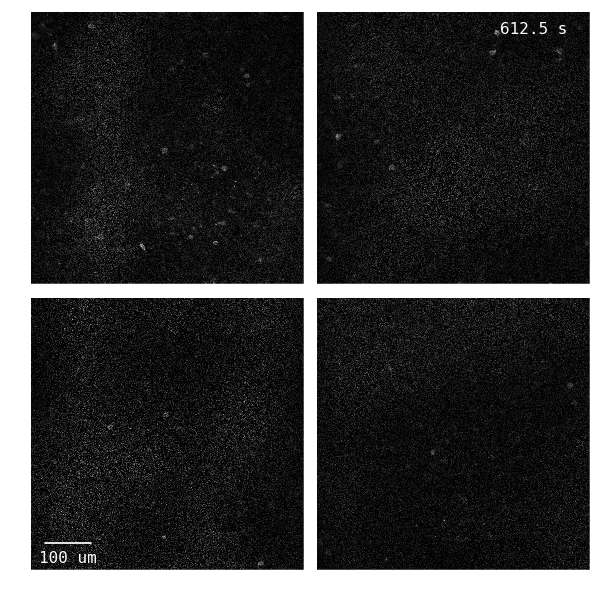

In [195]:
fig = plt.figure(figsize=[10,10])
frame = movie.shape[0]/2

axes, g = tile(movie[frame].transpose(1,2,0), clim=[(0, x*4) for x in clim], axis=2, fig=fig)

img = movie[frame,0]
time = g[1].text(.92*img.shape[1], .08*img.shape[0], '%.1f s' % (frame/frameRate), color='white', fontsize=16, ha='right', fontdict={'family': 'monospace'});
g[2].plot([.05*img.shape[1], .05*img.shape[1]+scaleBar*pixelsPerUm], [.9*img.shape[0], .9*img.shape[1]], 'w');
g[2].text(.05*img.shape[1]+scaleBar*pixelsPerUm/2, .975*img.shape[0], '%d um' % scaleBar, color='white', fontsize=16, ha='center', fontdict={'family': 'monospace'});
for i in range(4):
    g[i].set_xlim([0, img.shape[1]]);
    g[i].set_ylim([img.shape[0], 0]);

In [197]:
nframes = movie.shape[0]-dsTime

def update(frame):
    [axes[i].set_array(movie[frame+dsTime/2, i, :, :]) for i in range(movie.shape[1])]
    time.set_text('%.1f s' % ((frame+dsTime/2)/frameRate))

ani = animation.FuncAnimation(fig, update, nframes, blit=False)
ani.save(join(savepath, '%s_ds%d_fs%d_dt%d-%d.mp4' % (label, dsSpace, fSpace, dsTime, plane)), writer=writer)